In [1]:
import librosa
import os
import numpy as np
import pandas as pd
import glob, os
from dask.distributed import LocalCluster
from dask.diagnostics import ProgressBar

import argparse
import matplotlib.pyplot as plt
import shutil
from tensorflow.keras.layers import Input, Dense, GRU, Dropout
from tensorflow.keras import Model
import tensorflow
from tensorflow import keras

from tensorflow.keras import regularizers
from sklearn.utils import class_weight
from tensorflow.keras.models import load_model




In [2]:
# Mount GDrive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir("/content/drive/My Drive/EE599_HW6")

In [ ]:
top_db=30
train_file = '/content/drive/MyDrive/EE599_HW6/train/'
for subdir, dirs, files in os.walk(train_file): 
    for file in files:
      #print(subdir)
        print(file)
        y, sr = librosa.load(subdir + "/" + file ,sr=16000)
        # print(y)
        # intervals = librosa.effects.split(y, top_db=top_db)
        # y_new = np.zeros((1))
        # for interval in intervals:
        #     y_new = np.concatenate((y_new, y[interval[0]: interval[1]]))
        # print(y_new)
        if 'train_english' in subdir: 
            y= y[abs(y )>0.01]
            
            mat = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=64, n_fft =int(sr*0.025), hop_length = int(sr*0.010))
            preprocess_train_english = mat[:,0:1000].T
            train_seq_eng = np.append(train_seq_eng, preprocess_train_english)
        elif 'train_hindi' in subdir:
            y  = y [abs(y )>0.01]
            
            mat = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=64, n_fft =int(sr*0.025), hop_length = int(sr*0.010))
            preprocess_train_hindi = mat[:,0:1000].T
            train_seq_hindi = np.append(train_seq_hindi, preprocess_train_hindi)
        else:
            y = y[abs(y)>0.008]
            
            mat = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=64, n_fft =int(sr*0.025), hop_length = int(sr*0.010))
            preprocess_train_Mand = mat[:,0:1000].T
            train_seq_Mand = np.append(train_seq_Mand, preprocess_train_Mand)


hindi_0030.wav
hindi_0024.wav
hindi_0018.wav
hindi_0019.wav
hindi_0025.wav
hindi_0031.wav
hindi_0027.wav
hindi_0033.wav
hindi_0032.wav
hindi_0026.wav
hindi_0022.wav
hindi_0023.wav
hindi_0009.wav
hindi_0021.wav
hindi_0020.wav
hindi_0008.wav
hindi_0011.wav
hindi_0005.wav
hindi_0004.wav
hindi_0010.wav
hindi_0006.wav
hindi_0012.wav
hindi_0013.wav
hindi_0007.wav
hindi_0003.wav
hindi_0017.wav
hindi_0016.wav
hindi_0002.wav
hindi_0028.wav
hindi_0014.wav
hindi_0001.wav
hindi_0015.wav
hindi_0029.wav
english_0059.wav
english_0065.wav
english_0071.wav
english_0111.wav
english_0105.wav
english_0104.wav
english_0110.wav
english_0070.wav
english_0064.wav
english_0058.wav
english_0072.wav
english_0066.wav
english_0099.wav
english_0106.wav
english_0112.wav
english_0113.wav
english_0107.wav
english_0098.wav
english_0067.wav
english_0073.wav
english_0077.wav
english_0063.wav
english_0088.wav
english_0103.wav
english_0117.wav
english_0116.wav
english_0102.wav
english_0089.wav
english_0062.wav
english_0076

In [ ]:
print(train_seq_eng.shape)
print(train_seq_hindi.shape)
print(train_seq_Mand.shape)

print(preprocess_train_Mand.shape)

(7744000,)
(2112000,)
(5440000,)
(1000, 64)


In [ ]:
#Reshaping
English_SEQ = np.reshape(train_seq_eng, [121,1000,64])
Labels_eng = np.zeros([121,1000,1])
Hindi_SEQ = np.reshape(train_seq_hindi, [33,1000,64])
Labels_Hindi = np.ones([33,1000,1])
Mand_SEQ = np.reshape(train_seq_Mand, [85,1000,64])
Labels_Mand = np.ones([85,1000,1])*2

Train_data = np.vstack([English_SEQ,Hindi_SEQ, Mand_SEQ])
labels = np.vstack([Labels_eng, Labels_Hindi, Labels_Mand])
np.save('Train_data', Train_data)
np.save('Labels', labels)

In [ ]:
labelsf = np.reshape(labels, [239*1000, 1])
dataf = np.reshape(Train_data, [239*1000, 64])
rng_state = np.random.get_state()
np.random.shuffle(dataf)
np.random.set_state(rng_state)
np.random.shuffle(labelsf)
labels = np.reshape(labelsf, [239, 1000, 1])
Train_data = np.reshape(dataf, [239, 1000, 64])


In [4]:
Train_data = np.load('Train_data.npy')
labels = np.load('Labels.npy')

In [5]:
print(labels.shape)

(315, 1000, 1)


In [6]:
labelsf = np.reshape(labels, [315*1000, 1])
dataf = np.reshape(Train_data, [315*1000, 64])
rng_state = np.random.get_state()
np.random.shuffle(dataf)
np.random.set_state(rng_state)
np.random.shuffle(labelsf)
labels = np.reshape(labelsf, [315, 1000, 1])
Train_data = np.reshape(dataf, [315, 1000, 64])



print(Train_data .shape)
print(labels.shape)


(315, 1000, 64)
(315, 1000, 1)


In [7]:
lab = np.reshape(labels, [315*1000,])
class_weights = class_weight.compute_class_weight('balanced', np.unique(lab), lab)

In [9]:
# ######  Define/Build/Train Training Model
# training_in_shape = x.shape[1:]
# training_in = Input(shape=training_in_shape)
# # training_in = Input(batch_shape=(None,train_seq_length,feature_dim)) this works too
# foo = GRU(4, return_sequences=True, stateful=False)(training_in)
# training_pred = Dense(1)(foo)

# training_model = Model(inputs=training_in, outputs=training_pred)
# training_model.compile(loss='mean_squared_error', optimizer='adam')
# training_model.summary()
 
# training_model.fit(x, y, batch_size=2, epochs=100)


#Train Model
training_in_shape = Train_data.shape[1:]
training_in = Input(shape = training_in_shape)
Var = GRU(1240, return_sequences=True, stateful = False)(training_in)
training_pred = Dense(3, activation = 'softmax')(Var)

In [10]:
training_model = Model(inputs = training_in, outputs = training_pred)
training_model.compile(loss = keras.losses.SparseCategoricalCrossentropy(),
                      optimizer = 'adam',
                      metrics = ['accuracy'])
training_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000, 64)]        0         
_________________________________________________________________
gru (GRU)                    (None, 1000, 1240)        4858320   
_________________________________________________________________
dense (Dense)                (None, 1000, 3)           3723      
Total params: 4,862,043
Trainable params: 4,862,043
Non-trainable params: 0
_________________________________________________________________


In [12]:
results = training_model.fit(Train_data, labels, batch_size = 4, epochs = 20,
                            validation_split = 0.2, weights=class_weights)

Epoch 1/20
63/63 [==============================] - 15s 238ms/step - loss: 1.0958 - accuracy: 0.5018 - val_loss: 0.9143 - val_accuracy: 0.5487
Epoch 2/20
63/63 [==============================] - 15s 234ms/step - loss: 0.8927 - accuracy: 0.5673 - val_loss: 0.8761 - val_accuracy: 0.5873
Epoch 3/20
63/63 [==============================] - 15s 236ms/step - loss: 0.8539 - accuracy: 0.6046 - val_loss: 0.8593 - val_accuracy: 0.5967
Epoch 4/20
63/63 [==============================] - 15s 238ms/step - loss: 0.8264 - accuracy: 0.6261 - val_loss: 0.8297 - val_accuracy: 0.6298
Epoch 5/20
63/63 [==============================] - 15s 239ms/step - loss: 0.7994 - accuracy: 0.6475 - val_loss: 0.8114 - val_accuracy: 0.6413
Epoch 6/20
63/63 [==============================] - 15s 238ms/step - loss: 0.7820 - accuracy: 0.6565 - val_loss: 0.8004 - val_accuracy: 0.6473
Epoch 7/20
63/63 [==============================] - 15s 236ms/step - loss: 0.7613 - accuracy: 0.6713 - val_loss: 0.7938 - val_accuracy: 0.6501

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(1, None, 64)]           0         
_________________________________________________________________
gru_1 (GRU)                  (1, 1240)                 4858320   
_________________________________________________________________
dense_1 (Dense)              (1, 3)                    3723      
Total params: 4,862,043
Trainable params: 4,862,043
Non-trainable params: 0
_________________________________________________________________


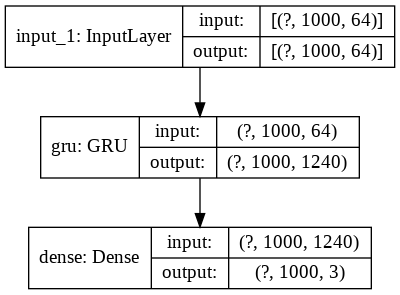

In [13]:
##### define the streaming-infernece model
streaming_in = Input(batch_shape=(1,None,64))  ## stateful ==> needs batch_shape specified
foo = GRU(1240, return_sequences=False, stateful=True )(streaming_in)
streaming_pred = Dense(3, activation = 'softmax')(foo)
streaming_model = Model(inputs=streaming_in, outputs=streaming_pred)

streaming_model.compile(loss = keras.losses.SparseCategoricalCrossentropy(),
                      optimizer = 'adam',
                      metrics = ['accuracy'])
streaming_model.summary()


###### copy the weights from trained model to streaming-inference model
training_model.save_weights('weights.hdf5', overwrite=True)
streaming_model.load_weights('weights.hdf5')
keras.utils.plot_model(training_model, to_file='Streaming_Model.png', show_shapes=True, show_layer_names=True)



******the streaming-inference model can replicate the sequence-based trained model:



Running Sequence 0 with STATE RESET:

[0.67665035 0.12242746 0.20092219]
[0.39797    0.10419966 0.49783042]
[0.62348    0.19339027 0.18312977]
[0.41122323 0.17810647 0.41067025]
[0.6642383  0.2237378  0.11202388]
[0.36370924 0.17547193 0.46081886]
[0.23948018 0.12746783 0.63305205]
[0.0808401  0.0538922  0.86526775]
[0.33085865 0.01074776 0.6583936 ]
[0.774194   0.01497133 0.21083461]
[0.8234371  0.05134393 0.12521906]
[0.08177238 0.397115   0.5211126 ]
[0.30090886 0.5225376  0.17655356]
[0.623402   0.17184678 0.20475125]
[0.38063926 0.02606308 0.59329766]
[0.15136564 0.33030823 0.5183261 ]
[0.7159335  0.08181728 0.20224917]
[0.46971613 0.48360056 0.04668334]
[0.5566758  0.02232899 0.42099524]
[0.87847835 0.11126647 0.01025515]


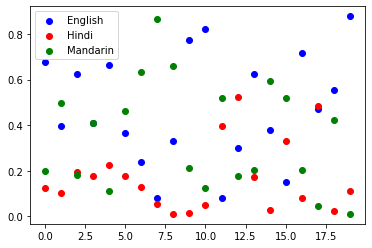

In [14]:
DEMO = 1
if DEMO:
    ##### demo the behaivor
    print('\n\n******the streaming-inference model can replicate the sequence-based trained model:\n')
    for s in range(1):
        print(f'\n\nRunning Sequence {s} with STATE RESET:\n')
        for n in range(20):
            in_feature_vector = Train_data[s][n].reshape(1,1,64)
            single_pred = streaming_model.predict(in_feature_vector)[0]
            print(single_pred)
            streaming_model.reset_states()
                  
            p1 = plt.scatter(n, single_pred[0], color = 'blue')
            p2 = plt.scatter(n, single_pred[1], color = 'red')
            p3 = plt.scatter(n, single_pred[2], color = 'green')
    p1.set_label('English')
    p2.set_label('Hindi')
    p3.set_label('Mandarin')
    plt.savefig('model_plot.png')
    plt.legend()
    plt.show()
                  

In [15]:
training_model.save('EE599_HW5_training_charu.hdf5')

In [16]:
training_model.save('EE599_HW5_Streaming_charu.hdf5')

In [17]:
#Provide Val_data with dimensions (Num_sequences, Num_samples, 64)

import librosa
import os
import numpy as np
import pandas as pd
import glob, os
from dask.distributed import LocalCluster
from dask.diagnostics import ProgressBar
import dask.bag as dbag
import argparse
import matplotlib.pyplot as plt
import shutil
from tensorflow.keras.layers import Input, Dense, GRU, Dropout
from tensorflow.keras import Model
import tensorflow
from tensorflow import keras

from tensorflow.keras import regularizers
from sklearn.utils import class_weight
from tensorflow.keras.models import load_model



streaming_model = load_model('EE599_HW5_Streaming.hdf5')

DEMO = 1
if DEMO:
    ##### demo the behaivor
    print('\n\n******the streaming-inference model can replicate the sequence-based trained model:\n')
    for s in range(Num_sequences):
        print(f'\n\nRunning Sequence {s} with STATE RESET:\n')
        for n in range(Num_samples):
            in_feature_vector = Val_data[s][n].reshape(1,1,64)
            single_pred = streaming_model.predict(in_feature_vector)[0]
            print(single_pred)
            streaming_model.reset_states()

ImportError: ignored